# Compare the v1.0 L3 and open L2 release data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

In [2]:
def clip_swot(ds, area):
    selection = (
        (ds.longitude > area[0]) &
        (ds.longitude < area[2]) &
        (ds.latitude > area[1]) &
        (ds.latitude < area[3]))
    selection = selection.compute()
    return ds.where(selection, drop=True)

# Remove flagged data
def apply_flag(dataflag, da, flags='good'):
    if flags == 'good':
        upperflag = 0
    elif flags == 'suspect':
        upperflag = 8192
    elif flags == 'degraded':
        upperflag = 262144
    elif flags == 'bad':
        upperflag = np.inf

    idx = dataflag <= upperflag

    return da.where(idx, np.nan)

def calc_ssha_l2_l3_dynamic(ds_l2, ds_l3, flags='good'):
    ssha = ds_l2['ssh_karin_2']\
        + ds_l2['height_cor_xover']\
        - ds_l3['mss'] \
        - ds_l2['solid_earth_tide']\
        - ds_l3['ocean_tide']\
        - ds_l2['pole_tide']\
        - ds_l2['dac']

    return apply_flag( ds['ssh_karin_2_qual'], ssha, flags=flags)

def calc_ssha_l2_l3_all(ds_l2, ds_l3, flags='good'):
    ssha = ds_l2['ssh_karin_2']\
        + ds_l3['calibration']\
        - ds_l3['mss'] \
        - ds_l2['solid_earth_tide']\
        - ds_l3['ocean_tide']\
        - ds_l2['pole_tide']\
        - ds_l2['dac']

    return apply_flag( ds['ssh_karin_2_qual'], ssha, flags=flags)

def plot_karin(da, 
            cmap="RdBu_r",
            vmin=-0.3,
            vmax=0.3,
            fig=None,
            ax=None):

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={"shrink": 0.3},)
    da.plot.pcolormesh(ax=ax, **plot_kwargs)
    ax.set_aspect('equal')
    #ax1.set_title(ds_area.satpass.values[ii])
    #plt.tight_layout()

In [3]:
region = 'browsebasin'
area = [120, -16, 125, -11] # Kimberley
cycle_no = 502
pass_no = 21

l2files = sorted(glob(f'/home/jupyter-mrayson/data/SWOT/l2_karin_v1_0/cycle_{cycle_no}/SWOT_L2_LR_SSH_Expert_*_0{pass_no}*.nc'))

l3files = sorted(glob(f'/home/jupyter-mrayson/data/SWOT/l3_karin_nadir_v1_0/cycle_{cycle_no}/*_0{pass_no}*.nc'))




In [4]:
ds_l2_ = xr.open_dataset(l2files[0])
ds_l3_ = xr.open_dataset(l3files[0])

ds_l2 = clip_swot(ds_l2_, area)
ds_l3 = clip_swot(ds_l3_, area)

ds = xr.merge([ds_l2, ds_l3], compat='override')
ds

/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                                (num_lines: 290, num_pixels: 69,
                                            num_sides: 2, num_nadir: 1309)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -1...
    longitude                              (num_lines, num_pixels) float64 12...
    latitude_nadir                         (num_lines) float64 -16.08 ... -10.92
    longitude_nadir                        (num_lines) float64 122.9 ... 123.7
Dimensions without coordinates: num_lines, num_pixels, num_sides, num_nadir
Data variables: (12/113)
    time                                   (num_lines, num_pixels) datetime64[ns] ...
    time_tai                               (num_lines, num_pixels) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 na...
    ssh_karin_qual                         (num_lines, num_pixels) float64 2....
    ssh_karin_uncert                       (num_lines, num_pixels) float32 na...
    ssha_karin                             (num_lines, num_pixels) float64 na...
    ...                                     ...
    vgos                                   (num_lines, num_pixels) float64 na...
    ugosa                                  (num_lines, num_pixels) float64 na...
    vgosa                                  (num_lines, num_pixels) float64 na...
    sigma0                                 (num_lines, num_pixels) float64 na...
    i_num_line                             (num_nadir, num_lines, num_pixels) float32 ...
    i_num_pixel                            (num_nadir, num_lines, num_pixels) float32 ...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   JPL
    source:                                        Ka-band radar interferometer
    history:                                       2023-12-29T07:46:02Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       60.8072438548036
    ssha_variance:                                 2.5567705907578038
    references:                                    V1.2.1
    equator_longitude:                             125.31

    Sea surface height anomaly from the KaRIn measurement = ssh_karin_2 - mean_sea_surface_cnescls - solid_earth_tide - ocean_tide_fes – internal_tide_hret - pole_tide - dac.

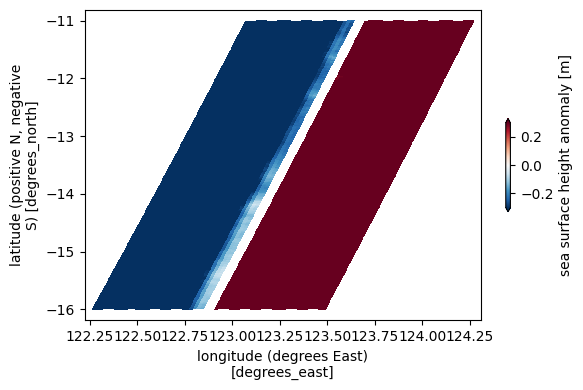

In [48]:
plot_karin(ds['ssha_karin_2'])

In [49]:
#L3 calibration
ds['calibration'].attrs

{'long_name': 'satellite calibration',
 'comment': 'phase screen + phase_screen_static + phase_screen_orbit + xcal. the uncorrected ssha can be computed as follows: [uncorrected ssha]=[ssha from product] + [calibration]; see the product user manual for details',
 'units': 'm'}

Text(0.5, 1.0, 'L3 w/ L3 correction')

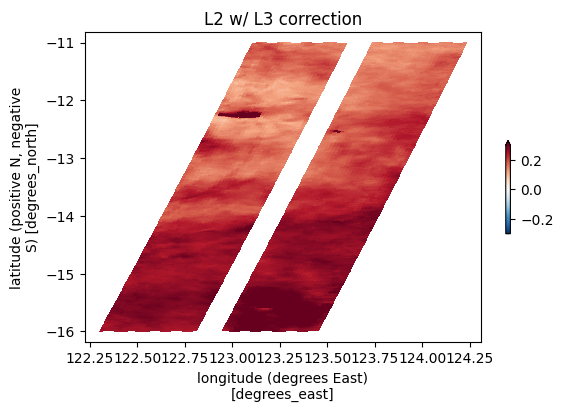

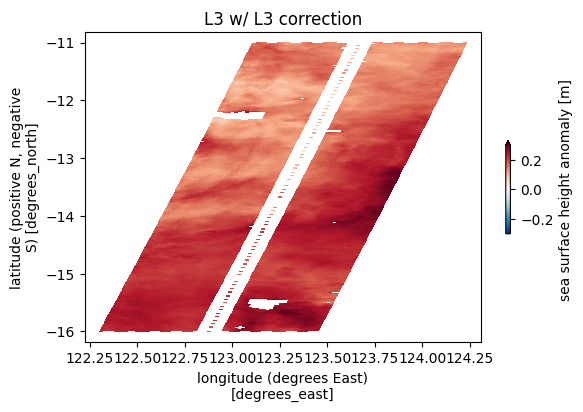

In [50]:
# Add L3 calibration
plot_karin(ds['ssha_karin_2']+ds['calibration'])
plt.title('L2 w/ L3 correction')

plot_karin(ds['ssha'])
plt.title('L3 w/ L3 correction')

Text(0.5, 1.0, 'L2 w/ L2 correction')

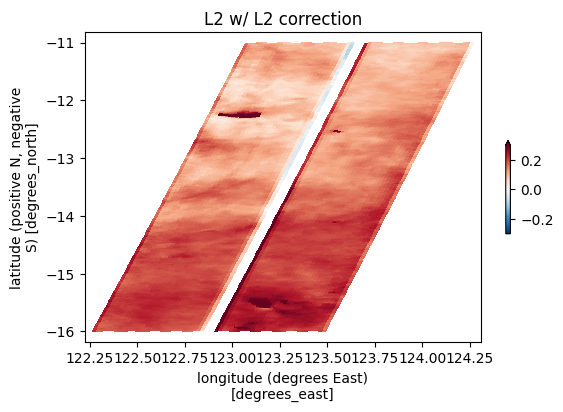

In [51]:
# L2 w/ L2 correction
plot_karin(ds['ssha_karin_2']+ds['height_cor_xover'])
plt.title('L2 w/ L2 correction')

In [52]:
ds['ssha_karin_2'].attrs

{'long_name': 'sea surface height anomaly',
 'units': 'm',
 'quality_flag': 'ssha_karin_2_qual',
 'valid_min': -1000000,
 'valid_max': 1000000,
 'comment': 'Sea surface height anomaly from the KaRIn measurement = ssh_karin_2 - mean_sea_surface_cnescls - solid_earth_tide - ocean_tide_fes – internal_tide_hret - pole_tide - dac.'}

Text(0.5, 1.0, 'L2 w/ L3  dynamic correction')

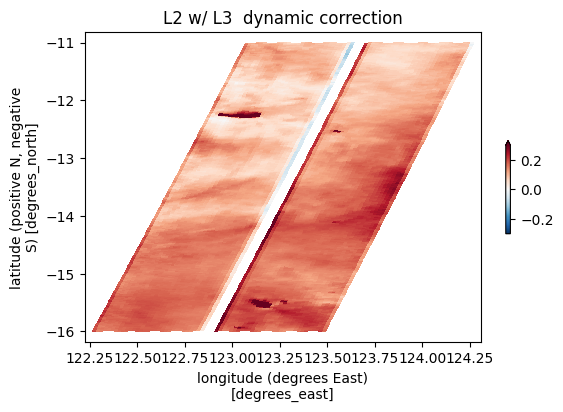

In [72]:
# L2 w/ L3 models (tides etc), L2 correction
ssha_l2_l3like = ds['ssh_karin_2']
    + ds['height_cor_xover']\
    - ds['mss'] \
    - ds['solid_earth_tide']\
    - ds['ocean_tide']\
    - ds['pole_tide']\
    - ds['dac']
    
    #-ds['mean_sea_surface_cnescls']\ # L2 mss\
    # - ds['internal_tide_hret']\ # L2 internal tide correction
    # - ds['ocean_tide_fes']\ # L2 tides

    #- ds['ocean_tide'] - ds['mss'] - ds['mdt']
    
plot_karin(ssha_l2_l3like)
plt.title('L2 w/ L3  dynamic correction')

Text(0.5, 1.0, 'L2 w/ L3  dynamic + phase correction')

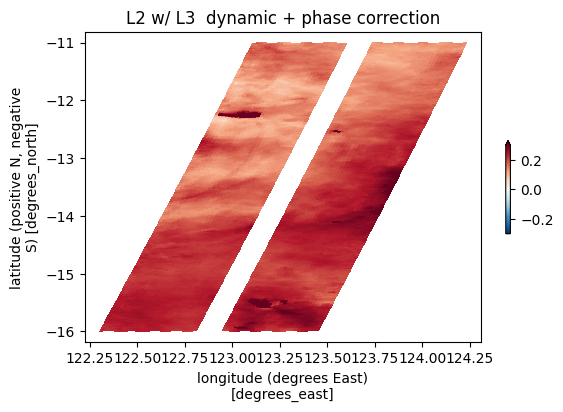

In [68]:
# L2 w/ L3 models (tides etc), L3 correction
ssha_l2_l3like_v2 = ds['ssh_karin_2']
    +ds['calibration']\
    - ds['mss'] \
    - ds['solid_earth_tide']\
    - ds['ocean_tide']\
    - ds['pole_tide']\
    - ds['dac']

    #-ds['mean_sea_surface_cnescls']\ # L2 mss\
    # - ds['internal_tide_hret']\ # L2 internal tide correction
    # - ds['ocean_tide_fes']\ # L2 tides

    #- ds['ocean_tide'] - ds['mss'] - ds['mdt']
    
plot_karin(ssha_l2_l3like_v2)
plt.title('L2 w/ L3  dynamic + phase correction')

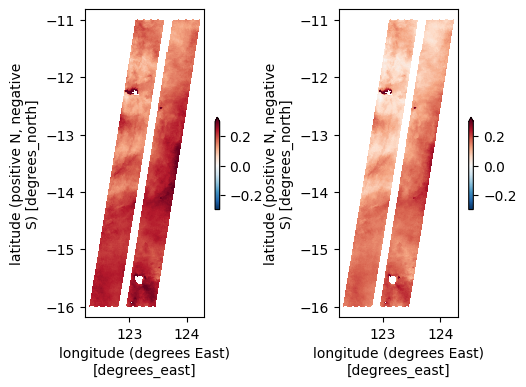

In [80]:


#dataflag = ds['ssh_karin_2_qual']
#plot_karin(apply_flag(dataflag, ssha_l2_l3like, flags='good'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
plot_karin(calc_ssha_l2_l3_all(ds, ds), fig=fig, ax=ax1)
plot_karin(calc_ssha_l2_l3_dynamic(ds, ds), fig=fig, ax=ax2)
